# Preview Our Dataset

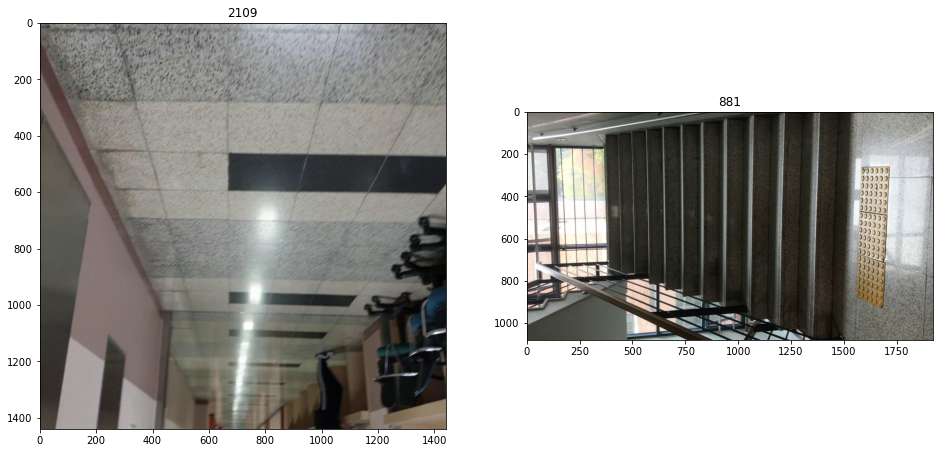

In [69]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

BASE_PATH = "C:\\Users\\USER\\Desktop\\rne_dataset\\"

hallway_list = glob.glob(os.path.join(BASE_PATH,'hallway\\*.jpg'))
stair_list = glob.glob(os.path.join(BASE_PATH,'stair\\*.jpg'))

hallway_img = img_to_array(load_img(hallway_list[0]),dtype = np.uint8)
stair_img = img_to_array(load_img(stair_list[0]),dtype=np.uint8)

plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.title(len(hallway_list))
plt.imshow(hallway_img)
plt.subplot(1,2,2)
plt.title(len(stair_list))
plt.imshow(stair_img)

# DataGenrator

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range= 10,
    width_shift_range=0.1,
    height_shift_range= 0.1,
    brightness_range= [0.8,1.2],
    shear_range= 0.01,
    zoom_range=[0.9,1.1],
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split= 0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size = (224,224),
    classes=['Hallway','Stair'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224,224),
    classes=['Hallway','Stair'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 2692 images belonging to 2 classes.
Found 298 images belonging to 2 classes.
{'Hallway': 0, 'Stair': 1}


# Load Model for Transfer Learning

In [9]:
base_model = MobileNetV2(input_shape=(224,224,3),  # MobileNetV2 이미 학습되어있는 모델을 내가 원하는 모델로 개조
                         weights='imagenet',
                         include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 데이터를 펴준다.
output = Dense(2, # 마지막 결과값은 Full:0, Free:1 두개의 이진 결과값이므로 Dense 는 2를 준다.
               activation='softmax')(x)

model = Model(inputs=base_model.input,
              outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

# Switch Layers to be trainable

In [10]:
for layer in model.layers:
    layer.trainable = True

# Train

In [11]:
#Train
history = model.fit_generator(train_gen, validation_data=val_gen,epochs =10, callbacks = [ModelCheckpoint(
    "model.h5",
    monitor='val_acc',
    save_best_only=True,
    verbose=1
)])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.0299 - acc: 0.9903
Epoch 00001: val_acc improved from -inf to 0.77852, saving model to model.h5
85/85 [==============================] - 510s 6s/step - loss: 0.0299 - acc: 0.9903 - val_loss: 2.1584 - val_acc: 0.7785
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.0101 - acc: 0.9978
Epoch 00002: val_acc did not improve from 0.77852
85/85 [==============================] - 419s 5s/step - loss: 0.0101 - acc: 0.9978 - val_loss: 17.8319 - val_acc: 0.2953
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.0184 - acc: 0.9955
Epoch 00003: val_acc did not improve from 0.77852
85/85 [==============================] - 370s 4s/step - loss: 0.0184 - acc: 0.9955 - val_loss: 3.6684 - val_acc: 0.5034
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.0311 - acc: 0.9937
Epoch 00004: val_acc did not i

# Create New Model

In [70]:
# Create New Model
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280,2)

new_model = Model(
    inputs = model.input,
    outputs=(
        model.layers[-3].output,
        model.layers[-1].output
    )
)

new_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

# Model Test

C:\Users\USER\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


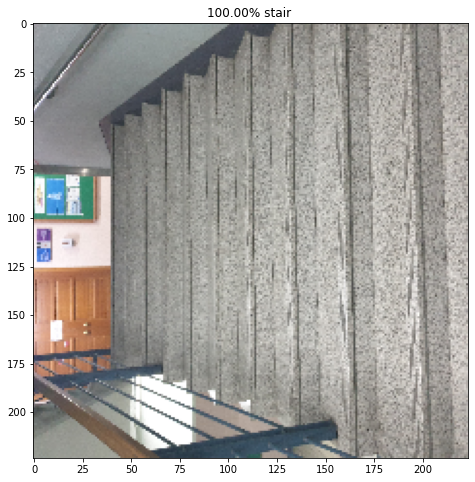

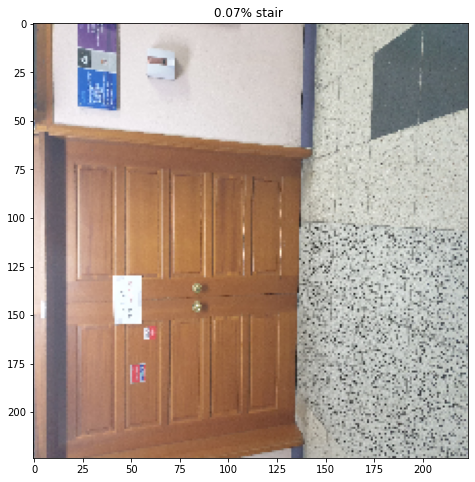

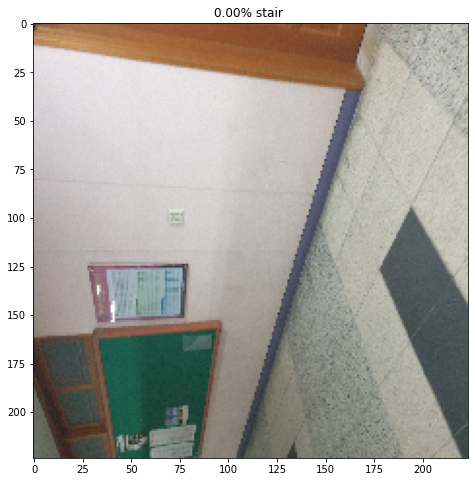

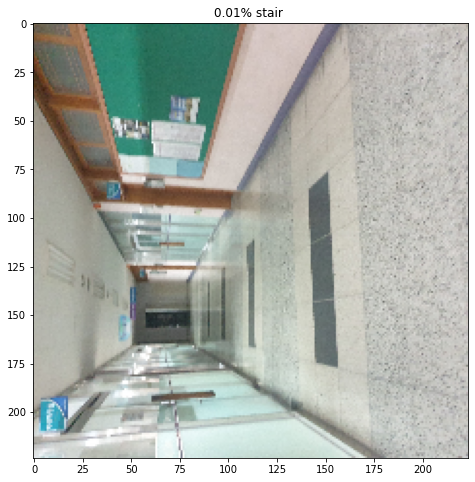

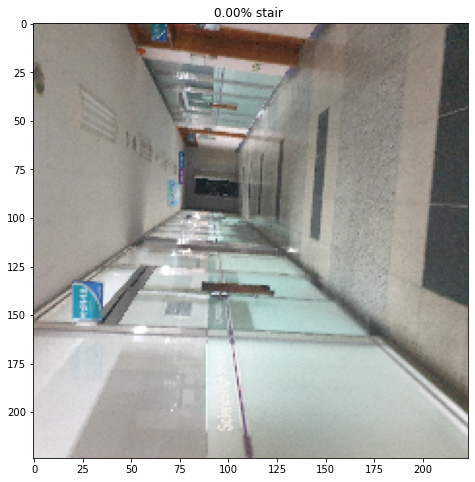

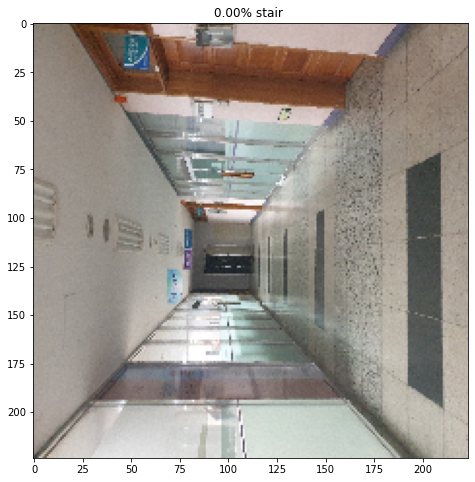

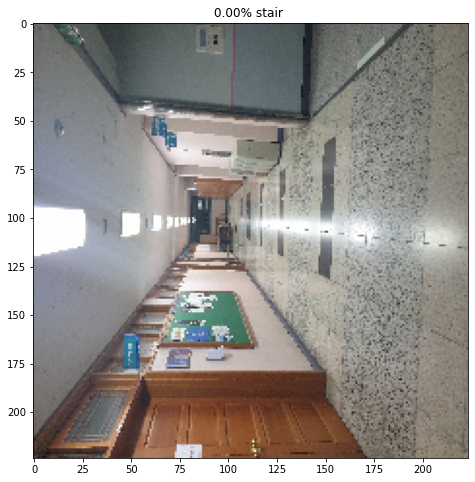

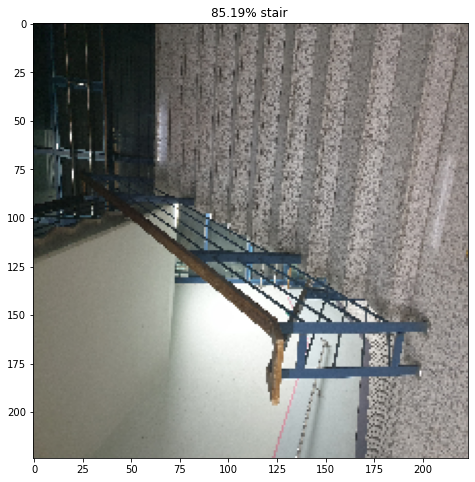

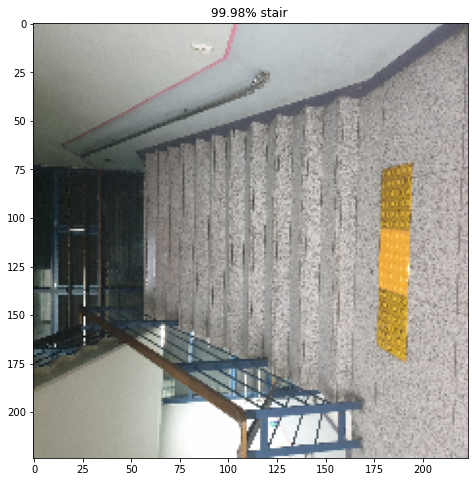

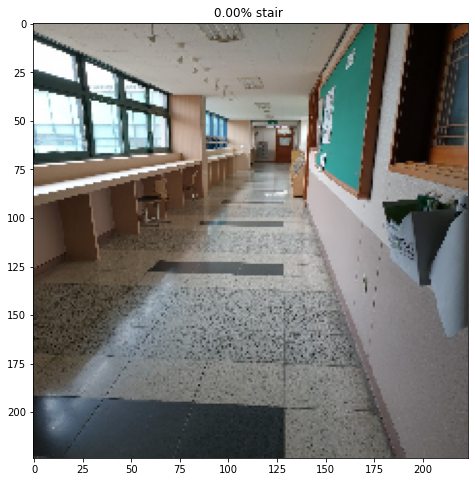

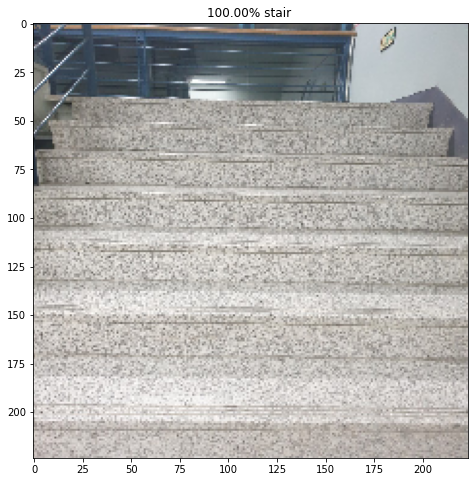

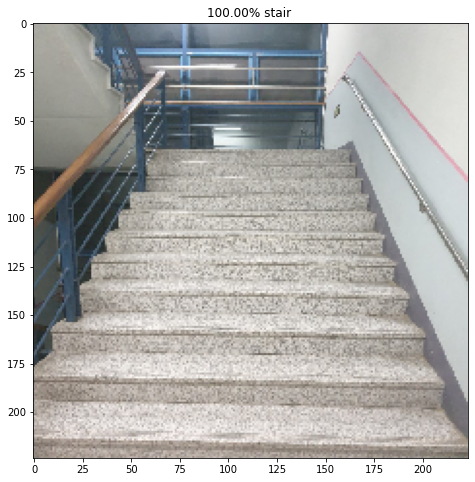

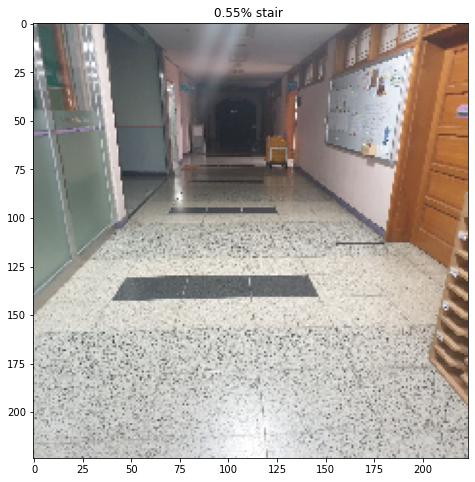

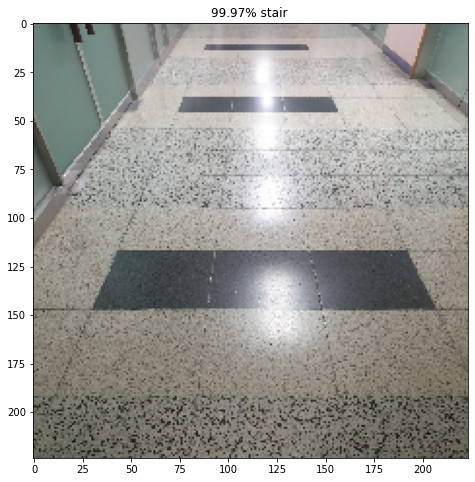

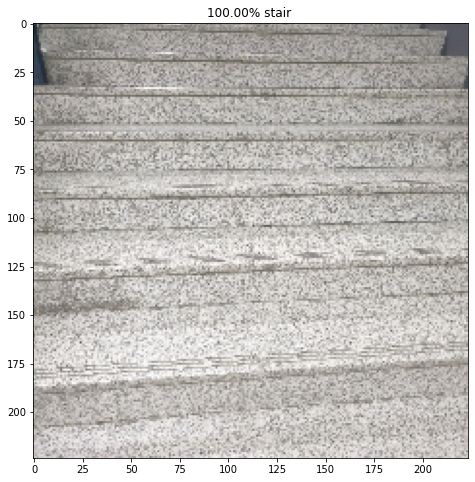

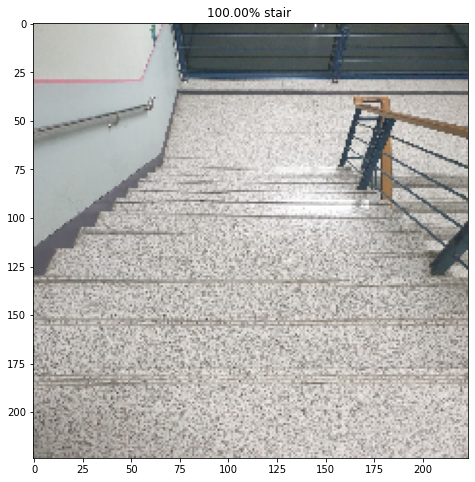

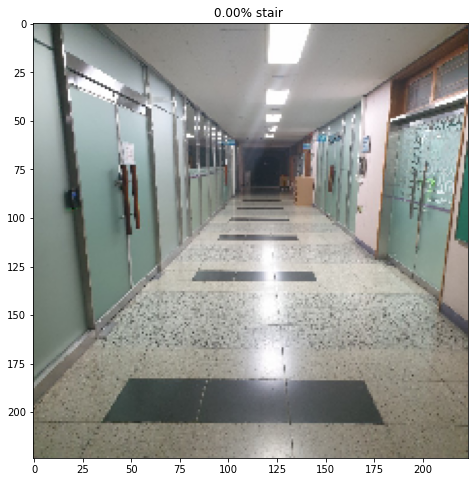

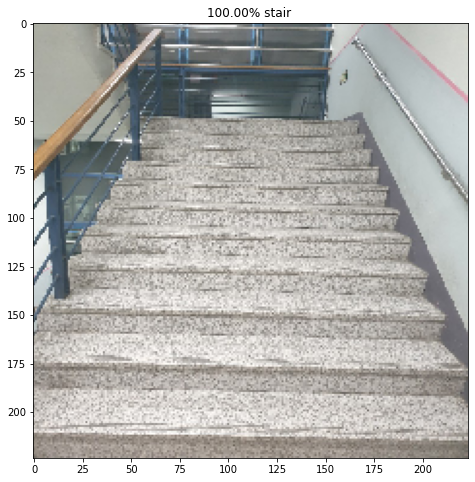

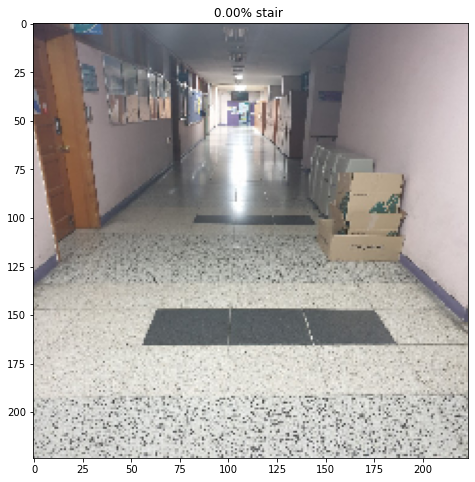

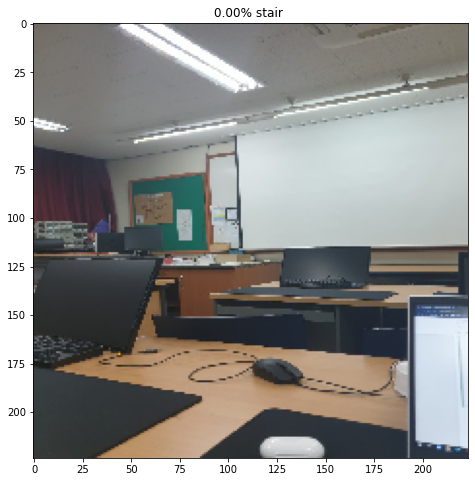

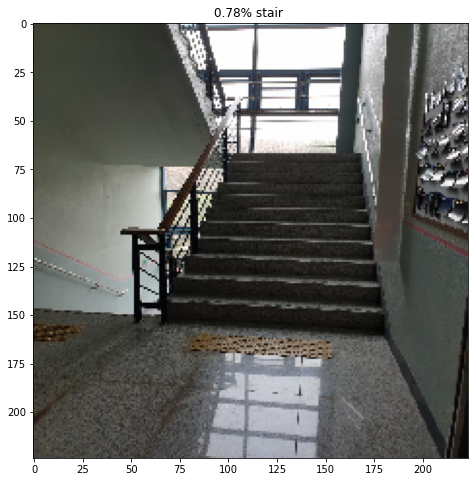

In [86]:
image_list=glob.glob(os.path.join(BASE_PATH,'test\\*.jpg'))

for image in image_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH,image), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0)) # 사진 전처리
    pred = model.predict(test_input) # 예측
    
    plt.figure(figsize=(8,8))
    plt.title('%.2f%% stair ' % (pred[0][1]*100))
    plt.imshow(test_img.astype(np.uint8))

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11315380661461704735,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8615880252786527962
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1546903887081811530
 physical_device_desc: "device: XLA_GPU device"]